In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
import numpy as np

In [16]:
products = pd.read_csv("../Data/product_library.csv", encoding="utf-8")
products = products[(products["category"]!="fun") & (products["product"]!="Pick 'n' Mix Box")]

categories = list(set(products["category"]))

product_count = len(products)

print(str(product_count) + " Products")

# What are the top ingredients?
products["ingredients"] = products["ingredients"].apply(lambda x: x[2:-2].replace("', '",",").split(","))
products["ingredient_count"] = products["ingredients"].apply(lambda x: len(list(x)))

ingredient_frequency = products.drop(["product",
                                      "category",
                                      "url",
                                      "ingredients",
                                      "ingredient_count"], axis=1).sum()

ingredients = list(ingredient_frequency.index)
print(str(len(ingredients)) + " Ingredients")
print("Top Ingredients:")
print(ingredient_frequency.sort_values(ascending=False).head())

129 Products
286 Ingredients
Top Ingredients:
Perfume               124
Limonene              109
Sodium Bicarbonate     86
Titanium Dioxide       84
Linalool               83
dtype: int64


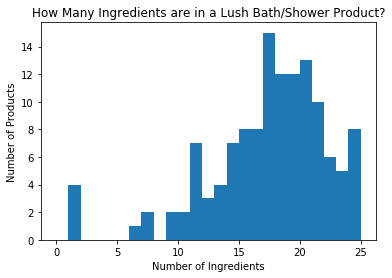

In [17]:
plt.hist(products["ingredient_count"],
         bins=[i for i in range(0, max(products["ingredient_count"])+1)])
plt.xlabel("Number of Ingredients")
plt.ylabel("Number of Products")
plt.title("How Many Ingredients are in a Lush Bath/Shower Product?")
plt.show()

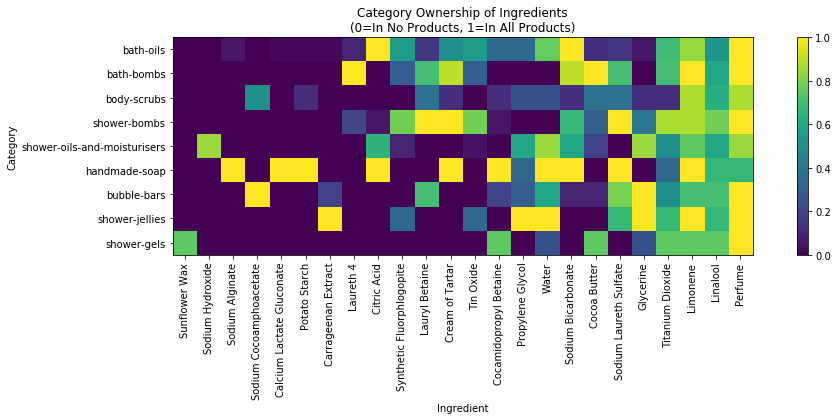

In [23]:
# Is there a strong association between some product categories and ingredients?
products_per_category = pd.pivot_table(products[["category","product"]], index="category", aggfunc="count")

melt_df = pd.melt(products[["product", "category"] + ingredients],id_vars=["product", "category"])

products_per_ingredient = pd.pivot_table(melt_df[melt_df["value"]>0],
                                         index=["category", "variable"], values=["product"],
                                         aggfunc={"product": "count"})

products_per_ingredient.reset_index(inplace=True, drop=False)
products_per_ingredient.rename(columns={"product": "product_count", "variable": "ingredient"}, inplace=True)
products_per_ingredient["category_size"] = products_per_ingredient["category"].apply(lambda x: products_per_category.loc[x]["product"])
products_per_ingredient["category_ownership"] = products_per_ingredient.apply(lambda x: x["product_count"]/x["category_size"], axis=1)

category_specificity = pd.pivot_table(products_per_ingredient,
                                      index="ingredient",
                                      columns="category",
                                      values="category_ownership")

del products_per_category, melt_df, products_per_ingredient

maximum_ownership = category_specificity.max(axis=1)
category_count = category_specificity.count(axis=1)

category_specificity["maximum_ownership"] = maximum_ownership
category_specificity["category_count"] = category_count
category_specificity.fillna(0, inplace=True)
category_specificity.sort_values(["category_count"], inplace=True)

del maximum_ownership, category_count

# As a heatmap - limit to most suspect ingredients
ownership_limit = 0.7

plt.figure(figsize=[16,4])
plt.imshow(np.transpose(category_specificity[category_specificity["maximum_ownership"] >= ownership_limit]
           .drop(["category_count", "maximum_ownership"], axis=1)),
           cmap='viridis')
plt.yticks(ticks=range(0,len(categories)), labels=categories)
plt.xticks(ticks=range(0,len(category_specificity[category_specificity["maximum_ownership"] >= ownership_limit])),
           labels=category_specificity[category_specificity["maximum_ownership"] >= ownership_limit].index,
           rotation=90)
plt.title("Category Ownership of Ingredients\n(0=In No Products, 1=In All Products)")
plt.xlabel("Ingredient")
plt.ylabel("Category")
plt.colorbar()
plt.show()

#category_specificity[category_specificity["maximum_ownership"] >= ownership_limit]

## How could this be made better?
<p>A relatively simple way to improve this analysis would be to create an ingredients dictionary which classifies an ingredient by the function it serves. The main classes would be:
<ul>
    <li>Functional - makes the product work</li>
    <li>Aesthetic - makes the product look, smell, or feel nicer</li>
    <li>Experiential - make the *experience* of using the product better</li>
    <li>Diluents - dilutes the raw materials for be usability, improved safety, improved cost, etc.</li>
    <li>Stabilizers - prevent product ingredients from separating, expiring, or losing features (e.g. color facde) over time</li>
    <li>Adjustment Agent - used to ensure final products have consistent characteristics, e.g. pH correction</li>
    <li>Production Aid - do not effect the usability of the final product but do make manufacturing/production easier, faster, and/or safer</li>
    <li>Claims - ingredients that make the product "special" in marketing terms and usually non-functional</li>
</ul>
Ingredients can have multiple classes such as a highly scented essential oil which improves the product aesthetic (masks functional ingredient odours), improves the product experience, and can be used as a claim. 
</p>

<p>This classification of ingredients in the Lush library means we could easily filter out the ingredients that do not serve an experiential or claim role. Creating the ingredients dictionary would require more data preparation and research at the start of the anaylysis, however it would be a better system than using my quick and dirty threshold.
An easy example of why this ingredient dictionary would be a good data asset is if there was a change in the stabilizers being used to create a product (something Lush is already working on with its self-preserving range).</p> <p>Let's assume that a new more sustainable stabilizing ingredient replaces an older ingredient. If Lush was to replace the old ingredient with the new ingredient in all products at the same time, then the threshold would still work. But it is more likely that there would be a period where the number of products featuring the new stabilizer that increased over time and would *eventually* reach the threshold for exclusion.</p>
<p>In fact, what we have seen at Lush is a two version approach where the old version and a new version with new stabilizer are both available for purchase. In fact, the new stabiliser is also acting as a claim ingredient (remember a claim ingredient is a marketing tool). This means our threshold approach will become less useful and less robust as the products become split between stabiliser A and stabiliser B forumlations.</p>

<p>For the time being, I'm going to stick with my threshold approach because it's my day off and I have other things that I want to get done today...</p>

## MVDA
### (If I care about format)

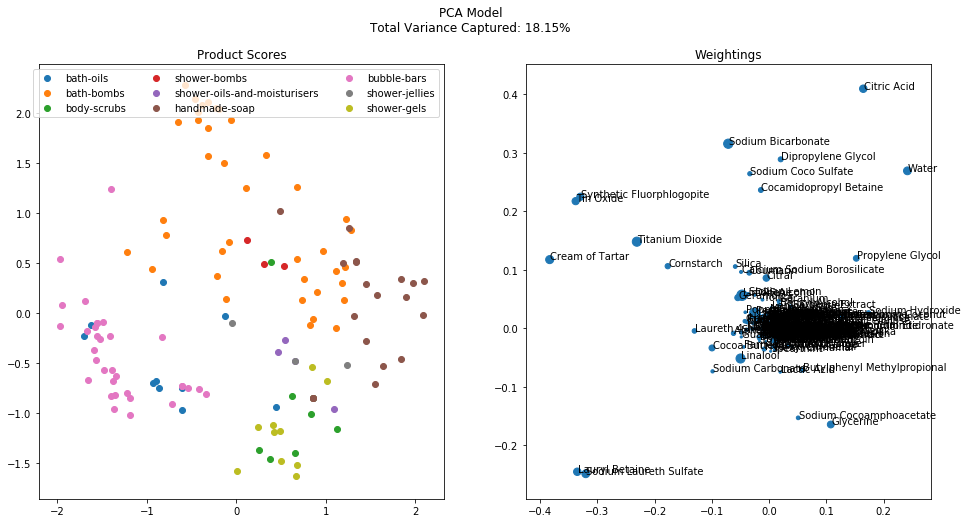

In [24]:
# Create PCA model
excl_cols = ["product","category","url","ingredients","ingredient_count"]

if "PC_1" in products.columns.tolist():
    excl_cols = excl_cols + ["PC_1", "PC_2"]

x_data = products.drop(excl_cols, axis=1).values

pca = PCA(n_components=2)
x_scores = pca.fit_transform(x_data)

# Product (Scores)
products["PC_1"] = [x[0] for x in x_scores]
products["PC_2"] = [x[1] for x in x_scores]

# Ingredient (Weightings)
wt_1 = pca.components_[0]
wt_2 = pca.components_[1]
wt_labels = [_l for _l in products.columns.tolist() if _l not in excl_cols +["PC_1", "PC_2"]]

wts = [[wt_labels[i], wt_1[i], wt_2[i]] for i in range(0,len(wt_labels))]
wt_df = pd.DataFrame(wts, columns=["ingredient", "PC_1", "PC_2"])

wt_df["dist_to_origin"] = wt_df.apply(lambda x: math.sqrt(x["PC_1"]**2 + x["PC_2"]**2), axis=1)
wt_df["product_frequency"] = wt_df["ingredient"].apply(lambda x: ingredient_frequency[x])

# Model Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,8])
fig.suptitle('PCA Model\nTotal Variance Captured: '+str(round(100*sum(pca.explained_variance_ratio_),2))+"%")

for _cat in categories:
    ax1.scatter(products[products["category"]==_cat]["PC_1"],
                products[products["category"]==_cat]["PC_2"], label=_cat)
#ax1.set_xticks(range(-5,6))
#ax1.set_yticks(range(-5,6))
ax1.legend(ncol=3)
ax1.set_title("Product Scores")

# Ingredient Weightings
# Reduce visual clutter from low-impact ingredients
min_dist_to_origin = 0.01

ax2.scatter(wt_df[wt_df["dist_to_origin"]> min_dist_to_origin]["PC_1"],
            wt_df[wt_df["dist_to_origin"]> min_dist_to_origin]["PC_2"],
            s=wt_df[wt_df["dist_to_origin"]> min_dist_to_origin]["product_frequency"])

for _ind in list(wt_df[wt_df["dist_to_origin"]> min_dist_to_origin].index):
    ax2.text(wt_df["PC_1"][_ind]+0.001,
             wt_df["PC_2"][_ind],
             wt_df["ingredient"][_ind])

ax2.set_title("Weightings")

plt.show()

## MVDA
### (If I don't care about format)

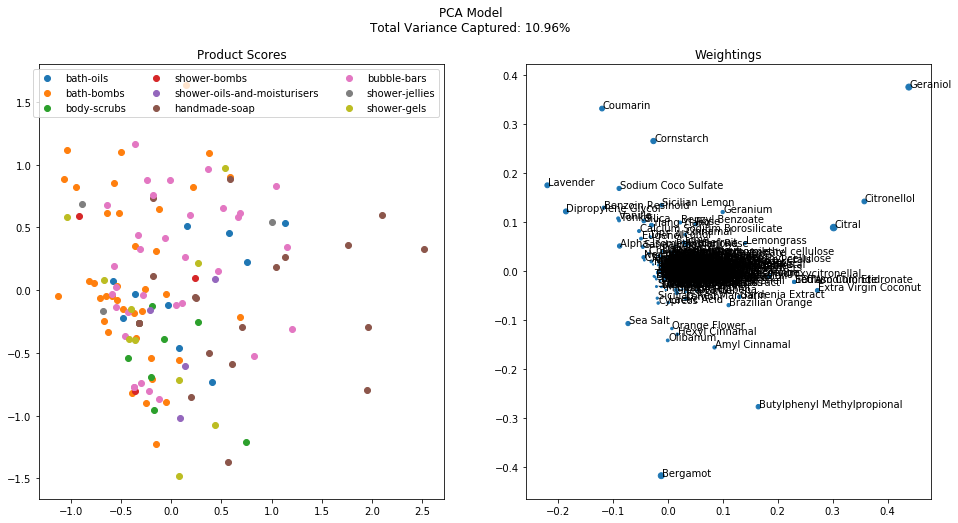

In [25]:
# Create PCA model
excl_ingredients = list(category_specificity[category_specificity["maximum_ownership"] >= ownership_limit].index)
excl_cols = ["product","category","url","ingredients","ingredient_count"]+excl_ingredients

if "PC_1" in products.columns.tolist():
    excl_cols = excl_cols + ["PC_1", "PC_2"]

x_data = products.drop(excl_cols, axis=1).values

pca = PCA(n_components=2)
x_scores = pca.fit_transform(x_data)

# Product (Scores)
products["PC_1"] = [x[0] for x in x_scores]
products["PC_2"] = [x[1] for x in x_scores]

# Ingredient (Weightings)
wt_1 = pca.components_[0]
wt_2 = pca.components_[1]
wt_labels = [_l for _l in products.columns.tolist() if _l not in excl_cols +["PC_1", "PC_2"]]

wts = [[wt_labels[i], wt_1[i], wt_2[i]] for i in range(0,len(wt_labels))]
wt_df = pd.DataFrame(wts, columns=["ingredient", "PC_1", "PC_2"])

wt_df["dist_to_origin"] = wt_df.apply(lambda x: math.sqrt(x["PC_1"]**2 + x["PC_2"]**2), axis=1)
wt_df["product_frequency"] = wt_df["ingredient"].apply(lambda x: ingredient_frequency[x])

# Model Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,8])
fig.suptitle('PCA Model\nTotal Variance Captured: '+str(round(100*sum(pca.explained_variance_ratio_),2))+"%")

for _cat in categories:
    ax1.scatter(products[products["category"]==_cat]["PC_1"],
                products[products["category"]==_cat]["PC_2"], label=_cat)
#ax1.set_xticks(range(-5,6))
#ax1.set_yticks(range(-5,6))
ax1.legend(ncol=3)
ax1.set_title("Product Scores")

# Ingredient Weightings
# Reduce visual clutter from low-impact ingredients
min_dist_to_origin = 0.01

ax2.scatter(wt_df[wt_df["dist_to_origin"]> min_dist_to_origin]["PC_1"],
            wt_df[wt_df["dist_to_origin"]> min_dist_to_origin]["PC_2"],
            s=wt_df[wt_df["dist_to_origin"]> min_dist_to_origin]["product_frequency"])

for _ind in list(wt_df[wt_df["dist_to_origin"]> min_dist_to_origin].index):
    ax2.text(wt_df["PC_1"][_ind]+0.001,
             wt_df["PC_2"][_ind],
             wt_df["ingredient"][_ind])

ax2.set_title("Weightings")

plt.show()

## How Badly do Lavender, Bergamot, and Geraniol Dominate the Library?

In [26]:
print("Bergamot: " + str(round(100*len(products[products["Bergamot"]==1])/product_count,2)) + "%")
print("Lavender: " + str(round(100*len(products[products["Lavender"]==1])/product_count,2)) + "%")
print("Geraniol: " + str(round(100*len(products[products["Geraniol"]==1])/product_count,2)) + "%")
print("Bergamot and Lavender: " + str(len(products[(products["Lavender"]==1) & (products["Bergamot"]==1)])))
print("Bergamot and Geraniol: " + str(len(products[(products["Geraniol"]==1) & (products["Bergamot"]==1)])))
print("Geraniol and Lavender: " + str(len(products[(products["Lavender"]==1) & (products["Geraniol"]==1)])))
print("Geraniol and Lavender and Bergamot: " + str(round(100*len(products[(((products["Bergamot"]==1) & (products["Lavender"]==1))
                                                                & (products["Geraniol"]==1))])/product_count,2)) + "%")
print("Geraniol or Lavender or Bergamot: " + str(round(100*len(products[(((products["Bergamot"]==1) | (products["Lavender"]==1))
                                                                | (products["Geraniol"]==1))])/product_count,2)) + "%")

Bergamot: 27.13%
Lavender: 18.6%
Geraniol: 27.91%
Bergamot and Lavender: 1
Bergamot and Geraniol: 5
Geraniol and Lavender: 5
Geraniol and Lavender and Bergamot: 0.0%
Geraniol or Lavender or Bergamot: 65.12%


# Let's Find Some Replacements!